# Introduction

Hello, I'm **Wesley**, nice to meet you! 👋

In this notebook, we will be training **six** different neural network architectures to show how **convolutions** helps improve image classification performance considerably despite using less parameters.

This is inspired by a [convolutional neural network (CNN)](https://en.wikipedia.org/wiki/Convolutional_neural_network) called [LeNet-5](https://paperswithcode.com/method/lenett) 👇, created by one of the AI Godfathers [Yann LeCun](https://en.wikipedia.org/wiki/Yann_LeCun), that popularized the use of [convolutions](https://en.wikipedia.org/wiki/Convolution) in deep learning. 

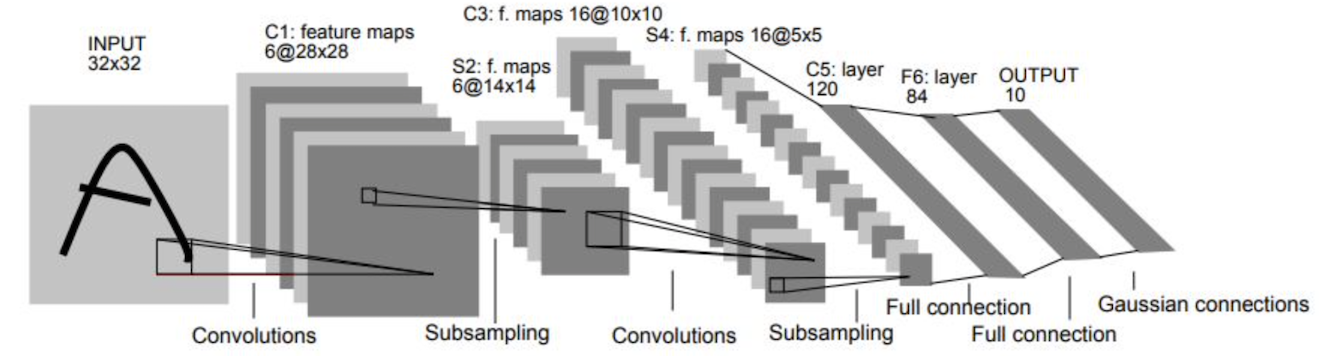

For fun, I made a *Cat vs Dog Dataset* from [CIFAR10](https://paperswithcode.com/dataset/cifar-10)  to compare these neural networks.

**TLDR**: Convolutions works!

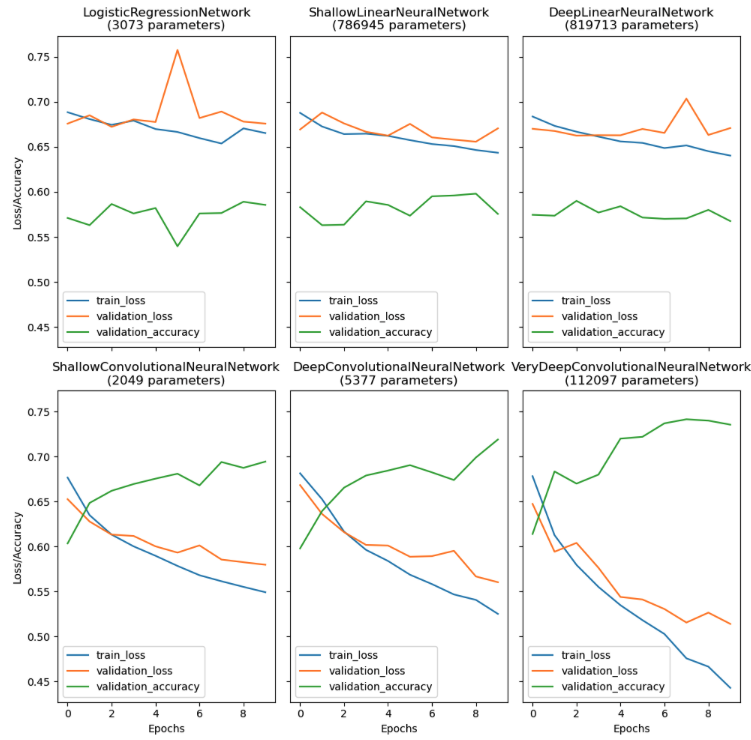

If you like this notebook, please **upvote** 👍 so that I know to make more of these fun projects to share with you. **Enjoy!** 😄

# Setup Python Libraries

In [1]:
%%bash
pip install numpy torch torchvision torchsummary datasets tqdm matplotlib --quiet
pip freeze | grep -E '^numpy|^torch|^torchvision|^torchsummary|^datasets|^tqdm|^matplotlib'

datasets==2.1.0
matplotlib==3.6.3
matplotlib-inline @ file:///home/conda/feedstock_root/build_artifacts/matplotlib-inline_1660814786464/work
matplotlib-venn==0.11.9
numpy==1.23.5
torch @ file:///tmp/torch/torch-2.0.0-cp310-cp310-linux_x86_64.whl#sha256=3a7abcaa5ae70fd4eb83c2cc43abc8ba94995316c6433e171d7454f107d41b58
torchaudio @ file:///tmp/torch/torchaudio-2.0.1-cp310-cp310-linux_x86_64.whl#sha256=83e258b68459f1ff64301c19c2fc791a692fd372271abeef8414854aafd03b06
torchdata==0.6.0
torchinfo==1.8.0
torchmetrics==0.11.4
torchsummary==1.5.1
torchtext @ file:///tmp/torch/torchtext-0.15.1-cp310-cp310-linux_x86_64.whl#sha256=110ca71f44e505c040ea2f41dcaf798cd7de1b55cbedaa6687b9e21eec759844
torchvision @ file:///tmp/torch/torchvision-0.15.1-cp310-cp310-linux_x86_64.whl#sha256=3b0e4e01ab713c145b7e20684eb79f983e75c8c13034901f21e3e8a36a1b3292
tqdm==4.64.1


# Create Cat vs Dog Dataset

## Clone Raw Dataset

In [2]:
# import required libraries

from datasets import load_dataset

In [3]:
# let's clone the cifar10 dataset with 10 classes that has both cats and dogs

raw_datasets = load_dataset('cifar10')
raw_datasets

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

## Exploratory Data Analysis

In [4]:
# import required libraries

import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
# let's see an example of the datset

example = raw_datasets['train'][0]
example

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
 'label': 0}

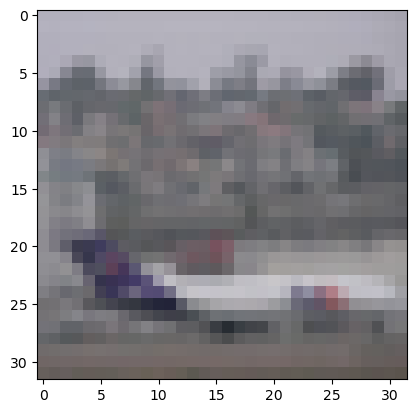

In [6]:
# let's see the PIL image with matplotlib

plt.imshow(example['img'])
plt.show()

In [7]:
# let's see what the label is: 'airplane'

ID2LABEL = {}
LABEL2ID = {}

for i,name in enumerate(raw_datasets['train'].features['label'].names):
    print(f"ID: {i} | LABEL: {name}")
    
    ID2LABEL[i] = name
    LABEL2ID[name] = i

ID: 0 | LABEL: airplane
ID: 1 | LABEL: automobile
ID: 2 | LABEL: bird
ID: 3 | LABEL: cat
ID: 4 | LABEL: deer
ID: 5 | LABEL: dog
ID: 6 | LABEL: frog
ID: 7 | LABEL: horse
ID: 8 | LABEL: ship
ID: 9 | LABEL: truck


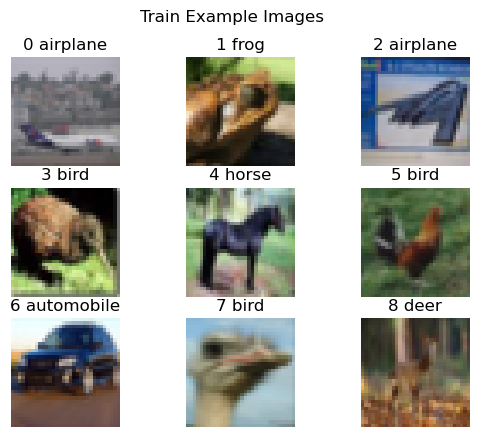

In [8]:
# let's check out more examples

fig, axs = plt.subplots(nrows=3, ncols=3)

fig.suptitle("Train Example Images")

for idx,ax in enumerate(axs.flat):
    img, label_id = raw_datasets['train'][idx].values()
    label = ID2LABEL[label_id]
    ax.axis('off')
    ax.set_title(f"{idx} {label}")
    ax.imshow(img)

## Create Cat vs Dog Dataset

In [9]:
# import required libraries

from collections import Counter
import matplotlib.pyplot as plt

%matplotlib inline

In [10]:
# for out dataset, we will only keep the longstanding comparison of cat vs. dog

catvsdog_datasets = raw_datasets.filter(lambda x: x['label'] in [LABEL2ID['cat'], LABEL2ID['dog']])
catvsdog_datasets

  0%|          | 0/50 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 2000
    })
})

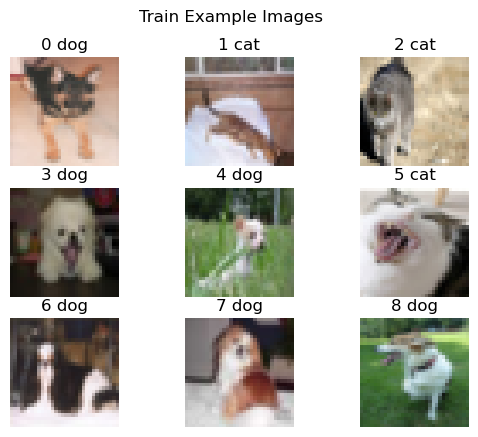

In [11]:
# let's make sure dog and cats are left in the dataset

fig, axs = plt.subplots(nrows=3, ncols=3)

fig.suptitle("Train Example Images")

for idx,ax in enumerate(axs.flat):
    img, label_id = catvsdog_datasets['train'][idx].values()
    label = ID2LABEL[label_id]
    ax.axis('off')
    ax.set_title(f"{idx} {label}")
    ax.imshow(img)

In [12]:
# let's double check the data imbalance to get a baseline accuracy

label_counts = Counter(catvsdog_datasets['train']['label'])
total_label_count = sum(label_counts.values())
label_percentages = {k:v/total_label_count for k,v in label_counts.items()}

print(f"LABEL_COUNTS: {label_counts}")
print(f"LABEL_PERCENTAGES: {label_percentages}")

LABEL_COUNTS: Counter({5: 5000, 3: 5000})
LABEL_PERCENTAGES: {5: 0.5, 3: 0.5}


In [13]:
# let's make make the label more clearer

label_counts = {ID2LABEL[k]:v for k,v in label_counts.items()}
label_percentages = {ID2LABEL[k]:v for k,v in label_percentages.items()}

print(f"LABEL_COUNTS: {label_counts}")
print(f"LABEL_PERCENTAGES: {label_percentages}")

LABEL_COUNTS: {'dog': 5000, 'cat': 5000}
LABEL_PERCENTAGES: {'dog': 0.5, 'cat': 0.5}


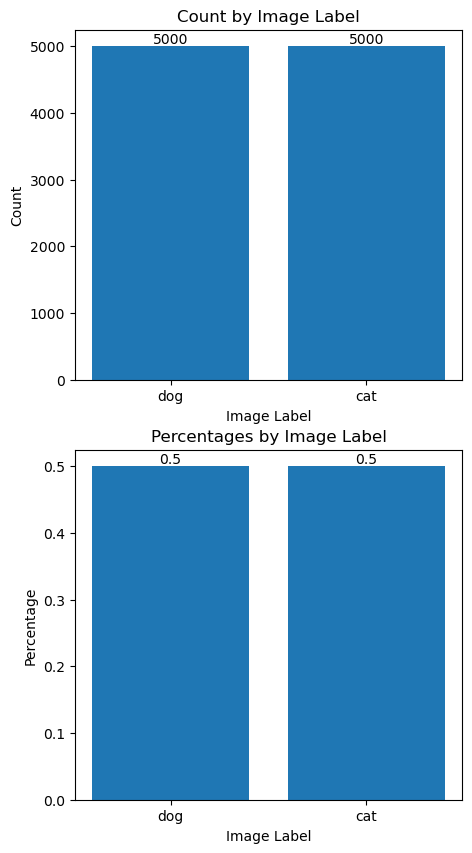

In [14]:
# let's plot the data imbalance: it's 50-50

fig, axs = plt.subplots(2,figsize=(5,10))

bar0 = axs[0].bar(label_counts.keys(), label_counts.values())
axs[0].bar_label(bar0, label_type='edge')
axs[0].set_title('Count by Image Label')
axs[0].set_xlabel('Image Label')
axs[0].set_ylabel('Count')

bar1 = axs[1].bar(label_percentages.keys(), label_percentages.values())
axs[1].bar_label(bar1, label_type='edge')
axs[1].set_title('Percentages by Image Label')
axs[1].set_xlabel('Image Label')
axs[1].set_ylabel('Percentage')

plt.show()

## Preprocess Datasets for Training

In [15]:
# import required libraries

import numpy as np
import torch
from datasets import DatasetDict

In [16]:
# let's see the seed for reproducibility

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

In [17]:
# let's make change the label for cat from 3 to 1 and dog from 5 to 0

def preprocess_labels(example):
    example['label'] =  int(example['label'] == LABEL2ID['cat'])
    return example
    
preprocessed_datasets = catvsdog_datasets.map(preprocess_labels)
preprocessed_datasets

  0%|          | 0/10000 [00:00<?, ?ex/s]

  0%|          | 0/2000 [00:00<?, ?ex/s]

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 2000
    })
})

In [18]:
# let's double check an preprocssed example with the label change

print(f"OLD: {catvsdog_datasets['train'][0]}")
print(f"NEW: {preprocessed_datasets['train'][0]}")

OLD: {'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7BCFDEEE50F0>, 'label': 5}
NEW: {'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7BCFDEEE49D0>, 'label': 0}


In [19]:
# let's split the dataset train-validaiton-test to 66%-16%-16%

_train_validation_datasets = preprocessed_datasets['train'].train_test_split(test_size=0.2, seed=SEED, shuffle=True)

preprocessed_datasets = DatasetDict({
    'train': _train_validation_datasets['train'],
    'validation': _train_validation_datasets['test'],
    'test': preprocessed_datasets['test']
})

preprocessed_datasets

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 8000
    })
    validation: Dataset({
        features: ['img', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 2000
    })
})

# Setup Training

## Setup Dataloaders

In [20]:
# import required libraries

from torchvision.transforms.functional import to_tensor
from torch.utils.data import DataLoader

In [21]:
# we create this collate function to stack images and labels properly for the dataloaders

def collate_fn(batch):
    # to_tensor converts PIL images into torch tensors
    imgs = torch.stack(list(map(lambda x: to_tensor(x['img']), batch)))
    # we convert labels to be float type for training
    labels = torch.stack(list(map(lambda x: torch.tensor([x['label']], dtype=torch.float32), batch)))
    return imgs, labels

In [22]:
# let's setup the dataloaders with the only train to shuffle during each epoch

dataloaders = {}
for dataset_type in preprocessed_datasets.keys():
    dataloaders[dataset_type] = DataLoader(
        dataset=preprocessed_datasets[dataset_type],
        batch_size=32,
        shuffle=(dataset_type == 'train'),
        collate_fn=collate_fn,
    )

dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7bcfdeee4160>,
 'validation': <torch.utils.data.dataloader.DataLoader at 0x7bcfdc37b730>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7bcfdc37b400>}

In [23]:
# let's get the current device for training the model
# for this notebook, a gpu is not needed but it'll make it go fast

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Setup Training Functions

In [24]:
# import required libraries

from tqdm.notebook import tqdm

In [25]:
# let's make the training function

def train(dataloader, model, loss_fn, optimizer):
    # setup storage variable
    train_loss = 0.
    
    # set to train mode to enable backprop
    model.train()
    for X, y in tqdm(dataloader, leave=False):
        # reset gradients
        optimizer.zero_grad()
        
        # move to current device 
        X, y = X.to(device), y.to(device)
        
        # get prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backprop and update optimizer
        loss.backward()
        optimizer.step()
        
        # accumulate metrics
        train_loss += loss.item()
          
    # compute metrics
    train_loss /= len(dataloader)
    return {'loss': train_loss}

In [26]:
# let's make the evaluation function

def evaluate(dataloader, model, loss_fn):
    # setup storage variables
    evaluate_loss = 0.
    evaluate_accuracy = 0.
    
    # set to eval mode
    model.eval()
    with torch.no_grad():
        for X, y in tqdm(dataloader, leave=False):
            # move data to current device
            X, y = X.to(device), y.to(device)
            
            # get prediction
            pred = model(X)
            
            # accumulate metrics
            evaluate_loss += loss_fn(pred, y).item()
            evaluate_accuracy += ((pred>0.50) == y).type(torch.float).sum().item()
            
    # compute metrics
    evaluate_loss /= len(dataloader)
    evaluate_accuracy /= len(dataloader.dataset)
    return {'loss': evaluate_loss, 'accuracy': evaluate_accuracy}

In [27]:
def print_model_metrics(epoch, train_metrics, validation_metrics):
    print(f"EPOCH {epoch}", end=" | ")
    print(f"TRAIN LOSS: {train_metrics['loss']:.5f}", end=" | ")
    print(f"VALIDATION LOSS: {validation_metrics['loss']:.5f}", end=" | ")
    print(f"VALIDATION ACCURACY: {validation_metrics['accuracy']:.5f}", end=" | ") 

In [28]:
# this function get the total number of parameters that are trained on

def get_total_parameters(model):
    return sum(layer.numel() for layer in model.parameters() if layer.requires_grad)

In [29]:
# this function plots the model metrics of one neural network

def plot_model_metrics(metrics):
    fig, axs = plt.subplots()

    axs.set_title(f"{metrics['name']}\n({metrics['total_parameters']} parameters)")
    for metric_key in ['train_loss', 'validation_loss', 'validation_accuracy']:
        axs.plot(range(NUM_EPOCHS), metrics[metric_key], label=metric_key)
    axs.legend()
    
    plt.show()

In [30]:
# this function consolidates all model metrics into a nice comparison multiplot

def plot_all_model_metrics(all_model_metrics):
    fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(10,10))

    for i, metrics in enumerate(all_model_metrics):
        ax = axs.flat[i]
        ax.set_title(f"{metrics['name']}\n({metrics['total_parameters']} parameters)")
        for metric_key in ['train_loss', 'validation_loss', 'validation_accuracy']:
            ax.plot(range(NUM_EPOCHS), metrics[metric_key], label=metric_key)
            ax.legend(loc='lower left')
            ax.set(xlabel='Epochs', ylabel='Loss/Accuracy')
            ax.label_outer()

    fig.tight_layout()
    plt.show()

In [31]:
def train_evaluate_plot(model):
    current_model_metrics = {
        'name': model.__class__.__name__,
        'total_parameters': get_total_parameters(model),
        'train_loss': [],
        'validation_loss': [],
        'validation_accuracy': [],
        'test_accuracy': None,
    }

    # train and evaluate model
    for epoch in tqdm(range(NUM_EPOCHS)):
        train_metrics = train(dataloaders['train'], model, loss_fn, optimizer)
        validation_metrics = evaluate(dataloaders['validation'], model, loss_fn)

        # accumulate metrics
        current_model_metrics['train_loss'].append(train_metrics['loss'])
        current_model_metrics['validation_loss'].append(validation_metrics['loss'])
        current_model_metrics['validation_accuracy'].append(validation_metrics['accuracy'])

        # print to notebook
        print_model_metrics(epoch+1, train_metrics, validation_metrics)

    # print test loss
    test_metrics = evaluate(dataloaders['test'], model, loss_fn)
    print(f"TEST ACCURACY: {test_metrics['accuracy']:.5f}")
    current_model_metrics['test_accuracy'] = test_metrics['accuracy']
        
    # plot current model metrics
    plot_model_metrics(current_model_metrics)

    return current_model_metrics

# Train Models

**Goal:**
* We will be training **6** different neural network models with linear and convolutional units on the **Cat vs Dog custom dataset**.

**Model Types:**
1. **LogisticRegressionNetwork**: 1-layer neural network / traditional logistic regression classifier
2. **ShallowLinearNeuralNetwork**: 2-layer linear neural network
3. **DeepLinearNeuralNetwork**: 3-layer linear neural network
4. **ShallowConvolutionalNeuralNetwork**: 2-layer convolutional neural network
5. **DeepConvolutionalNeuralNetwork**: 3-layer convolutional neural network
6. **VeryDeepConvolutionalNeuralNetwork**: 5-layer convolutional neural network with both hidden convolutional and linear units

**Model Architecture Specifications:**
* All activations between layers are non-linear ReLUs
* All convolutional units with same padding will be paired with max pooling 
* Both convolutional and max pooling units with have kernel size 3x3 and stride 1

**Model Training Specifications:**
* Loss function will be Binary Cross Entropy
* Optimizer will be Adam with default learning rate of 0.001 and no weight decay
* No learning schedule used
* We will train for 10 epochs with train shuffling

**Note**
* Although I called them *linear* neural networks, they can learn *non-linear* representations through the *non-linear* ReLU activations

In [32]:
# import required libraries

from torch import nn
from torchsummary import summary

In [33]:
# set constants and variables

NUM_EPOCHS = 10
INPUT_SHAPE = (3,32,32)

# list to keep all model metrics below
all_model_metrics = []

In [34]:
# we will first train a logistic regression to get a baseline performance

class LogisticRegressionNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=3*32*32, out_features=1),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        return self.stack(x)
    
# setup model
model = LogisticRegressionNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.BCELoss()

# print model summary
summary(model, INPUT_SHAPE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                    [-1, 1]           3,073
           Sigmoid-3                    [-1, 1]               0
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 0.01
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 1 | TRAIN LOSS: 0.68849 | VALIDATION LOSS: 0.67584 | VALIDATION ACCURACY: 0.57100 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 2 | TRAIN LOSS: 0.68086 | VALIDATION LOSS: 0.68507 | VALIDATION ACCURACY: 0.56300 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 3 | TRAIN LOSS: 0.67449 | VALIDATION LOSS: 0.67230 | VALIDATION ACCURACY: 0.58650 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 4 | TRAIN LOSS: 0.67917 | VALIDATION LOSS: 0.68045 | VALIDATION ACCURACY: 0.57600 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 5 | TRAIN LOSS: 0.66983 | VALIDATION LOSS: 0.67766 | VALIDATION ACCURACY: 0.58200 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 6 | TRAIN LOSS: 0.66657 | VALIDATION LOSS: 0.75773 | VALIDATION ACCURACY: 0.53950 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 7 | TRAIN LOSS: 0.65976 | VALIDATION LOSS: 0.68205 | VALIDATION ACCURACY: 0.57600 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 8 | TRAIN LOSS: 0.65372 | VALIDATION LOSS: 0.68922 | VALIDATION ACCURACY: 0.57650 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 9 | TRAIN LOSS: 0.67053 | VALIDATION LOSS: 0.67808 | VALIDATION ACCURACY: 0.58900 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 10 | TRAIN LOSS: 0.66534 | VALIDATION LOSS: 0.67587 | VALIDATION ACCURACY: 0.58550 | 

  0%|          | 0/63 [00:00<?, ?it/s]

TEST ACCURACY: 0.60450


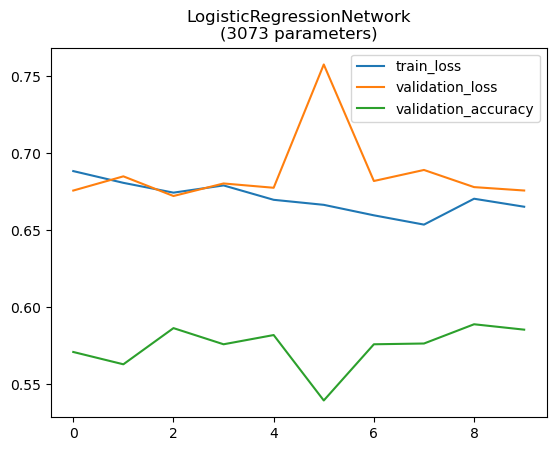

In [35]:
# let's train the model, evaluate on validation and test datasets, and plot the results
# we store this results to the all_model_metrics list for later use

model_metric = train_evaluate_plot(model)
all_model_metrics.append(model_metric)

In [36]:
# we add a hidden linear layer with a non-linear ReLU activation

class ShallowLinearNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=3*32*32, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=1),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        return self.stack(x)
    
# setup model training
model = ShallowLinearNeuralNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.BCELoss()

# print model summary
summary(model, INPUT_SHAPE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                  [-1, 256]         786,688
              ReLU-3                  [-1, 256]               0
            Linear-4                    [-1, 1]             257
           Sigmoid-5                    [-1, 1]               0
Total params: 786,945
Trainable params: 786,945
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 3.00
Estimated Total Size (MB): 3.04
----------------------------------------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 1 | TRAIN LOSS: 0.68777 | VALIDATION LOSS: 0.66935 | VALIDATION ACCURACY: 0.58300 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 2 | TRAIN LOSS: 0.67265 | VALIDATION LOSS: 0.68815 | VALIDATION ACCURACY: 0.56300 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 3 | TRAIN LOSS: 0.66420 | VALIDATION LOSS: 0.67606 | VALIDATION ACCURACY: 0.56350 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 4 | TRAIN LOSS: 0.66467 | VALIDATION LOSS: 0.66677 | VALIDATION ACCURACY: 0.58950 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 5 | TRAIN LOSS: 0.66225 | VALIDATION LOSS: 0.66248 | VALIDATION ACCURACY: 0.58550 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 6 | TRAIN LOSS: 0.65749 | VALIDATION LOSS: 0.67551 | VALIDATION ACCURACY: 0.57350 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 7 | TRAIN LOSS: 0.65318 | VALIDATION LOSS: 0.66054 | VALIDATION ACCURACY: 0.59500 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 8 | TRAIN LOSS: 0.65086 | VALIDATION LOSS: 0.65801 | VALIDATION ACCURACY: 0.59600 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 9 | TRAIN LOSS: 0.64653 | VALIDATION LOSS: 0.65577 | VALIDATION ACCURACY: 0.59800 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 10 | TRAIN LOSS: 0.64347 | VALIDATION LOSS: 0.67054 | VALIDATION ACCURACY: 0.57550 | 

  0%|          | 0/63 [00:00<?, ?it/s]

TEST ACCURACY: 0.59100


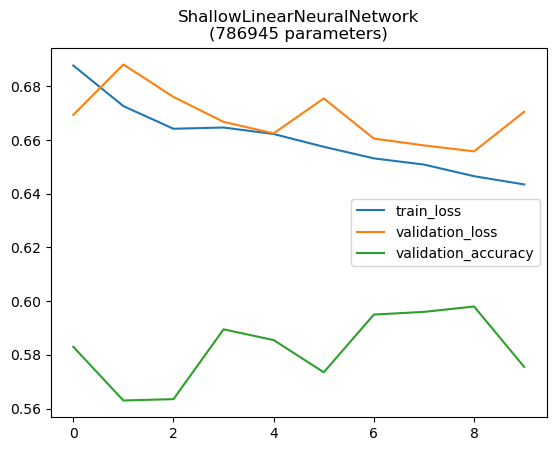

In [37]:
# let's train the model, evaluate on validation and test datasets, and plot the results
# we store this results to the all_model_metrics list for later use

model_metric = train_evaluate_plot(model)
all_model_metrics.append(model_metric)

In [38]:
# we add another linear layer but decrease its neurons by half

class DeepLinearNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=3*32*32, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=1),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        return self.stack(x)
    
# setup model training
model = DeepLinearNeuralNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.BCELoss()

# print model summary
summary(model, INPUT_SHAPE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                  [-1, 256]         786,688
              ReLU-3                  [-1, 256]               0
            Linear-4                  [-1, 128]          32,896
              ReLU-5                  [-1, 128]               0
            Linear-6                    [-1, 1]             129
           Sigmoid-7                    [-1, 1]               0
Total params: 819,713
Trainable params: 819,713
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 3.13
Estimated Total Size (MB): 3.17
----------------------------------------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 1 | TRAIN LOSS: 0.68375 | VALIDATION LOSS: 0.67012 | VALIDATION ACCURACY: 0.57450 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 2 | TRAIN LOSS: 0.67339 | VALIDATION LOSS: 0.66763 | VALIDATION ACCURACY: 0.57350 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 3 | TRAIN LOSS: 0.66683 | VALIDATION LOSS: 0.66254 | VALIDATION ACCURACY: 0.59000 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 4 | TRAIN LOSS: 0.66137 | VALIDATION LOSS: 0.66300 | VALIDATION ACCURACY: 0.57700 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 5 | TRAIN LOSS: 0.65607 | VALIDATION LOSS: 0.66289 | VALIDATION ACCURACY: 0.58400 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 6 | TRAIN LOSS: 0.65442 | VALIDATION LOSS: 0.66994 | VALIDATION ACCURACY: 0.57150 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 7 | TRAIN LOSS: 0.64870 | VALIDATION LOSS: 0.66553 | VALIDATION ACCURACY: 0.57000 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 8 | TRAIN LOSS: 0.65162 | VALIDATION LOSS: 0.70359 | VALIDATION ACCURACY: 0.57050 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 9 | TRAIN LOSS: 0.64515 | VALIDATION LOSS: 0.66324 | VALIDATION ACCURACY: 0.58000 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 10 | TRAIN LOSS: 0.64029 | VALIDATION LOSS: 0.67092 | VALIDATION ACCURACY: 0.56750 | 

  0%|          | 0/63 [00:00<?, ?it/s]

TEST ACCURACY: 0.59450


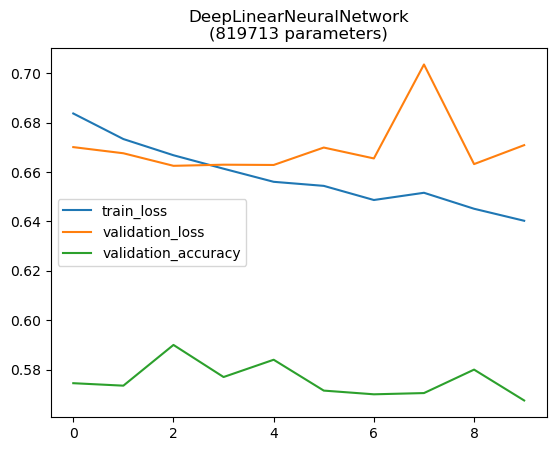

In [39]:
# let's train the model, evaluate on validation and test datasets, and plot the results
# we store this results to the all_model_metrics list for later use

model_metric = train_evaluate_plot(model)
all_model_metrics.append(model_metric)

In [40]:
# we replace the linear layers from previously with one convolutional unit with max pooling and a relu activation

class ShallowConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding='same'),
            nn.MaxPool2d(kernel_size=3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=16*10*10, out_features=1),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        return self.stack(x)
    
# setup model training
model = ShallowConvolutionalNeuralNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.BCELoss()

# print model summary
summary(model, INPUT_SHAPE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         MaxPool2d-2           [-1, 16, 10, 10]               0
              ReLU-3           [-1, 16, 10, 10]               0
           Flatten-4                 [-1, 1600]               0
            Linear-5                    [-1, 1]           1,601
           Sigmoid-6                    [-1, 1]               0
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.16
Params size (MB): 0.01
Estimated Total Size (MB): 0.18
----------------------------------------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 1 | TRAIN LOSS: 0.67671 | VALIDATION LOSS: 0.65267 | VALIDATION ACCURACY: 0.60350 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 2 | TRAIN LOSS: 0.63480 | VALIDATION LOSS: 0.62758 | VALIDATION ACCURACY: 0.64750 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 3 | TRAIN LOSS: 0.61341 | VALIDATION LOSS: 0.61368 | VALIDATION ACCURACY: 0.66300 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 4 | TRAIN LOSS: 0.60069 | VALIDATION LOSS: 0.61289 | VALIDATION ACCURACY: 0.66750 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 5 | TRAIN LOSS: 0.58989 | VALIDATION LOSS: 0.60068 | VALIDATION ACCURACY: 0.67500 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 6 | TRAIN LOSS: 0.57861 | VALIDATION LOSS: 0.59364 | VALIDATION ACCURACY: 0.68000 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 7 | TRAIN LOSS: 0.56842 | VALIDATION LOSS: 0.60115 | VALIDATION ACCURACY: 0.66600 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 8 | TRAIN LOSS: 0.56167 | VALIDATION LOSS: 0.58640 | VALIDATION ACCURACY: 0.69200 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 9 | TRAIN LOSS: 0.55500 | VALIDATION LOSS: 0.58337 | VALIDATION ACCURACY: 0.68850 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 10 | TRAIN LOSS: 0.54914 | VALIDATION LOSS: 0.58125 | VALIDATION ACCURACY: 0.69650 | 

  0%|          | 0/63 [00:00<?, ?it/s]

TEST ACCURACY: 0.70000


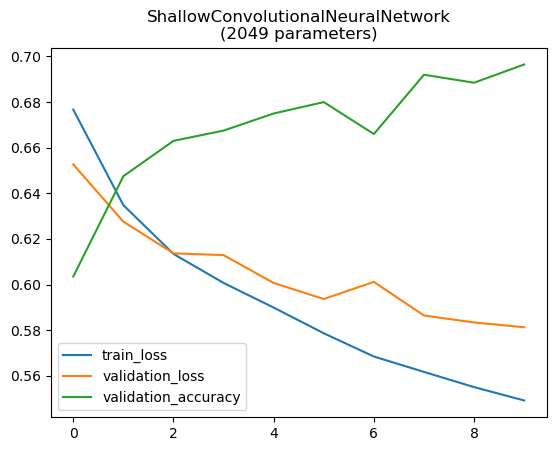

In [41]:
# let's train the model, evaluate on validation and test datasets, and plot the results

model_metric = train_evaluate_plot(model)
all_model_metrics.append(model_metric)

In [42]:
# we add another convolutional unit and a relu activation in between and increasing channel size

class DeepConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding='same'),
            nn.MaxPool2d(kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='same'),
            nn.MaxPool2d(kernel_size=3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=32*3*3, out_features=1),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        return self.stack(x)
    
# setup model
model = DeepConvolutionalNeuralNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.BCELoss()

summary(model, INPUT_SHAPE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         MaxPool2d-2           [-1, 16, 10, 10]               0
              ReLU-3           [-1, 16, 10, 10]               0
            Conv2d-4           [-1, 32, 10, 10]           4,640
         MaxPool2d-5             [-1, 32, 3, 3]               0
              ReLU-6             [-1, 32, 3, 3]               0
           Flatten-7                  [-1, 288]               0
            Linear-8                    [-1, 1]             289
           Sigmoid-9                    [-1, 1]               0
Total params: 5,377
Trainable params: 5,377
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.18
Params size (MB): 0.02
Estimated Total Size (MB): 0.21
-----------------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 1 | TRAIN LOSS: 0.68139 | VALIDATION LOSS: 0.66952 | VALIDATION ACCURACY: 0.59550 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 2 | TRAIN LOSS: 0.65310 | VALIDATION LOSS: 0.63652 | VALIDATION ACCURACY: 0.63800 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 3 | TRAIN LOSS: 0.61845 | VALIDATION LOSS: 0.61687 | VALIDATION ACCURACY: 0.66700 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 4 | TRAIN LOSS: 0.59815 | VALIDATION LOSS: 0.60366 | VALIDATION ACCURACY: 0.67250 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 5 | TRAIN LOSS: 0.58567 | VALIDATION LOSS: 0.60126 | VALIDATION ACCURACY: 0.68100 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 6 | TRAIN LOSS: 0.57115 | VALIDATION LOSS: 0.58821 | VALIDATION ACCURACY: 0.69000 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 7 | TRAIN LOSS: 0.56095 | VALIDATION LOSS: 0.59776 | VALIDATION ACCURACY: 0.67650 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 8 | TRAIN LOSS: 0.55100 | VALIDATION LOSS: 0.60338 | VALIDATION ACCURACY: 0.66800 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 9 | TRAIN LOSS: 0.54392 | VALIDATION LOSS: 0.57165 | VALIDATION ACCURACY: 0.69850 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 10 | TRAIN LOSS: 0.53003 | VALIDATION LOSS: 0.56530 | VALIDATION ACCURACY: 0.71300 | 

  0%|          | 0/63 [00:00<?, ?it/s]

TEST ACCURACY: 0.70100


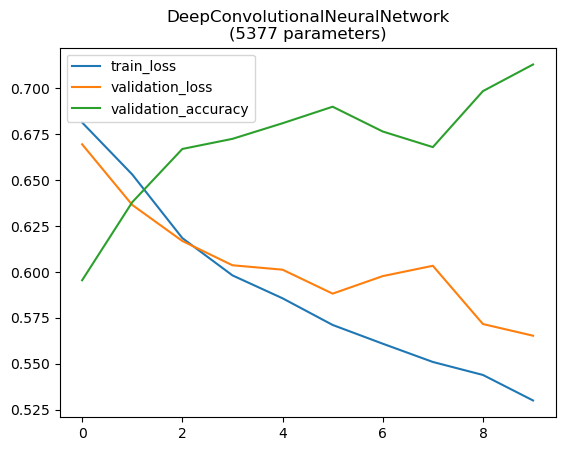

In [43]:
# let's train the model, evaluate on validation and test datasets, and plot the results
# we store this results to the all_model_metrics list for later use

model_metric = train_evaluate_plot(model)
all_model_metrics.append(model_metric)

In [44]:
# we add linear units after the convolutional linear units with non-linear relu activations

class VeryDeepConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding='same'),
            nn.MaxPool2d(kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='same'),
            nn.MaxPool2d(kernel_size=3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=32*3*3, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=1),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        return self.stack(x)
    
# setup model
model = VeryDeepConvolutionalNeuralNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.BCELoss()

# print model summary
summary(model, INPUT_SHAPE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         MaxPool2d-2           [-1, 16, 10, 10]               0
              ReLU-3           [-1, 16, 10, 10]               0
            Conv2d-4           [-1, 32, 10, 10]           4,640
         MaxPool2d-5             [-1, 32, 3, 3]               0
              ReLU-6             [-1, 32, 3, 3]               0
           Flatten-7                  [-1, 288]               0
            Linear-8                  [-1, 256]          73,984
              ReLU-9                  [-1, 256]               0
           Linear-10                  [-1, 128]          32,896
             ReLU-11                  [-1, 128]               0
           Linear-12                    [-1, 1]             129
          Sigmoid-13                    [-1, 1]               0
Total params: 112,097
Trainable params:

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 1 | TRAIN LOSS: 0.67959 | VALIDATION LOSS: 0.65249 | VALIDATION ACCURACY: 0.60450 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 2 | TRAIN LOSS: 0.61631 | VALIDATION LOSS: 0.59724 | VALIDATION ACCURACY: 0.67400 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 3 | TRAIN LOSS: 0.57727 | VALIDATION LOSS: 0.59054 | VALIDATION ACCURACY: 0.69000 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 4 | TRAIN LOSS: 0.54670 | VALIDATION LOSS: 0.58754 | VALIDATION ACCURACY: 0.67550 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 5 | TRAIN LOSS: 0.52585 | VALIDATION LOSS: 0.54241 | VALIDATION ACCURACY: 0.71500 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 6 | TRAIN LOSS: 0.50865 | VALIDATION LOSS: 0.53460 | VALIDATION ACCURACY: 0.72800 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 7 | TRAIN LOSS: 0.48683 | VALIDATION LOSS: 0.52646 | VALIDATION ACCURACY: 0.73700 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 8 | TRAIN LOSS: 0.46253 | VALIDATION LOSS: 0.52727 | VALIDATION ACCURACY: 0.73650 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 9 | TRAIN LOSS: 0.45141 | VALIDATION LOSS: 0.51730 | VALIDATION ACCURACY: 0.75000 | 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

EPOCH 10 | TRAIN LOSS: 0.42435 | VALIDATION LOSS: 0.52742 | VALIDATION ACCURACY: 0.74400 | 

  0%|          | 0/63 [00:00<?, ?it/s]

TEST ACCURACY: 0.74900


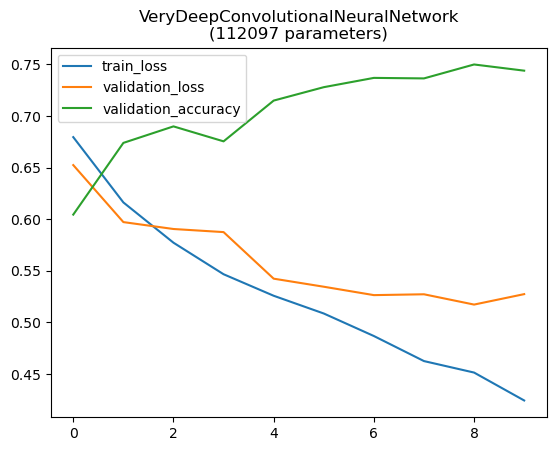

In [45]:
# let's train the model, evaluate on validation and test datasets, and plot the results
# we store this results to the all_model_metrics list for later use

model_metric = train_evaluate_plot(model)
all_model_metrics.append(model_metric)

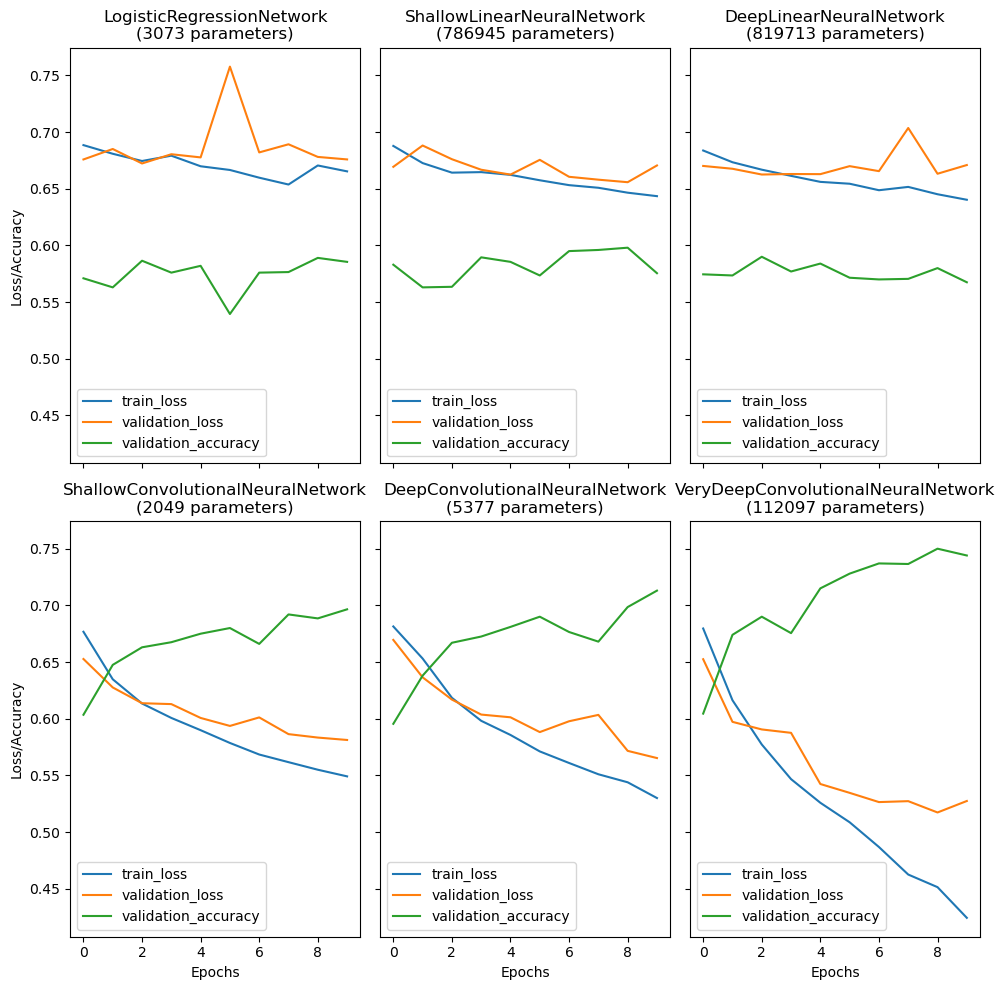

In [46]:
plot_all_model_metrics(all_model_metrics)

# Conclusion

Based on the above table of graphs, we can conclude a few things:
1. Neural networks with only linear layers such as **LogisticRegressionNetwork**, **ShallowLinearNeuralNetwork**, and **DeepLinearNeuralNetwork** had a hard time learning image representations based on the marginal improvements in their training loss.
2. Merely using 1 convolution unit with max pooling improved the training loss considerably despite using less parameters then the linear neural networks (**2049 vs 3073, 786945, 819713**), showing that convolutions learn image representations well.
3. Adding more convolutional layers helped improve performance based on the training loss and validation accuracy improvements between **DeepConvolutionalNeuralNetwork** and **ShallowConvolutionalNeuralNetwork**.
4. Adding linear layers after convolutional layers helped imporve performance even more, speeding up reducing in training loss while increasing validation accuracy.
5. Despite having used less parameters with convolutional neural networks than linear neural networks, they increased training speed and validation accuracy.


**Take Away**
* Use **convolutions** in your neural network for learning image classification! 😆